In [1]:
%matplotlib inline

# Websites recognition example using eigenWebsites and SVMs

In [2]:
from time import time
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import joblib

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.utils.fixes import loguniform
from sklearn.pipeline import Pipeline

Bringing the data

In [3]:
website_ds = pd.read_csv('../../dataset.csv')

# verify
website_ds.groupby('label').head(2)

,file_name,label,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,...,x_8810,x_8811,x_8812,x_8813,x_8814,x_8815,x_8816,x_8817,x_8818,x_8819
0,amazon00.png,amazon,0.379437,0.36479,0.028076,0.379437,0.379437,0.379437,0.357514,0.379437,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,amazon01.png,amazon,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
260,bbc00.png,bbc,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
261,bbc01.png,bbc,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
522,cnn00.png,cnn,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
523,cnn01.png,cnn,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
787,ebay00.png,ebay,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.272831,0.000000,0.000000,0.000000,0.047093,0.960016,0.000000,0.000000,0.000000,0.041418
788,ebay01.png,ebay,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.272831,0.000000,0.000000,0.000000,0.047093,0.960016,0.000000,0.000000,0.000000,0.041418
1049,github100.png,github,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1050,github101.png,github,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Data preperation

In [4]:
n_samples = website_ds.shape[0]

X = website_ds.drop(["label", "file_name"], axis=1)
website_features = website_ds.drop(["label", "file_name"], axis=1)
n_features = website_features.shape[1]

# the label to predict is the domain of the website
y = website_ds["label"].copy()
target_names = list(set(website_ds["label"].copy()))
n_classes = len(target_names)

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 2590
n_features: 8820
n_classes: 10


Split into a training set and a test and keep 25% of the data for testing.



In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Compute a PCA (eigenWebsites) on the Website dataset (treated as unlabeled
dataset): unsupervised feature extraction / dimensionality reduction



In [6]:
n_components = 150

print(
    "Extracting the top %d eigenWebsites from %d Websites" % (n_components, X_train.shape[0])
)
t0 = time()
pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

print("Projecting the input data on the eigenWebsites orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenWebsites from 1942 Websites
done in 2.195s
Projecting the input data on the eigenWebsites orthonormal basis
done in 0.215s


Train a SVM classification model



In [7]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {
    "C": loguniform(1e3, 1e5),
    "gamma": loguniform(1e-4, 1e-1),
}
clf = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10
)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 18.900s
Best estimator found by grid search:
SVC(C=6694.35266429909, class_weight='balanced', gamma=0.007133192487656371)


Quantitative evaluation of the model quality on the test set



Predicting Websites on the test set
done in 0.233s
              precision    recall  f1-score   support

         cnn       0.92      0.94      0.93        65
        ebay       0.99      0.94      0.96        70
      google       0.86      0.94      0.89        63
         bbc       0.92      0.95      0.93        58
     youtube       0.99      1.00      0.99        68
      github       0.98      1.00      0.99        54
     spiegel       1.00      1.00      1.00        74
      amazon       1.00      0.99      0.99        69
    njuskalo       0.98      0.94      0.96        67
 theguardian       0.98      0.92      0.95        60

    accuracy                           0.96       648
   macro avg       0.96      0.96      0.96       648
weighted avg       0.96      0.96      0.96       648



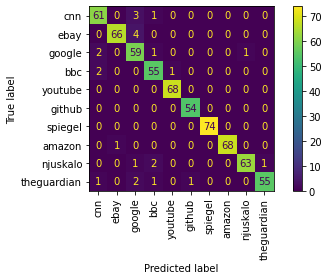

In [8]:
print("Predicting Websites on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
ConfusionMatrixDisplay.from_estimator(
    clf, X_test_pca, y_test, display_labels=target_names, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

Print the result of the prediction on a portion of the test set

In [9]:
def title(y_pred, y_test, target_names, i):
    pred_name = y_pred[i]
    true_name = y_test.to_list()[i]
    return "Predicted: %s ---- True: %s" % (pred_name, true_name)


prediction_titles = [
    title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])
]

display(prediction_titles[:10])

['Predicted: github ---- True: github',
 'Predicted: github ---- True: github',
 'Predicted: youtube ---- True: youtube',
 'Predicted: bbc ---- True: bbc',
 'Predicted: cnn ---- True: cnn',
 'Predicted: amazon ---- True: amazon',
 'Predicted: bbc ---- True: bbc',
 'Predicted: njuskalo ---- True: njuskalo',
 'Predicted: github ---- True: github',
 'Predicted: amazon ---- True: amazon']

Save pipeline for future use

In [11]:
pipeline = Pipeline(
    [
     ('scaler', scaler), 
     ('feature_selection', pca), 
     ('classifier', clf.best_estimator_)
    ]
)

joblib.dump(pipeline, '../../models/svm_best_pipeline.joblib')

['../../models/svm_best_pipeline.joblib']